# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure. Each machine failed immediately after the last recorded timestamp in the remote monitoring timeseries data.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

In [401]:
#!pip3 install statsmodels
#!pip3 install ipdb
#!pip3 install seaborn
#!pip3 install rpy2
#!pip3 install lifelines
#!pip3 install keras
#!pip3 install tensorflow

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,305
unique,2
top,warning
freq,304


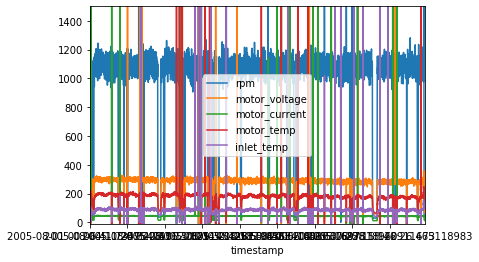

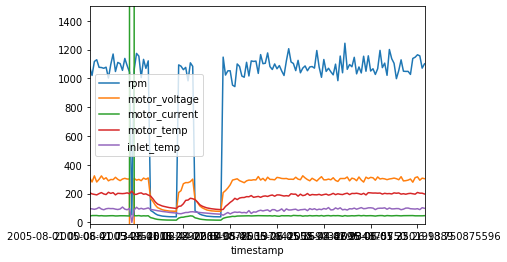

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

import lifelines as ll
import seaborn as sns
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
    
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

## Data processing

In [103]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

from lifelines import KaplanMeierFitter
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
import itertools

import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

plotly.tools.set_credentials_file(username='kempegowda.a', api_key='cF870W5z9vOzGeP0O5iv')

In [120]:
class RMS(object):
    
    def __init__(self, rms_path=None, alarm_path=None):
        if rms_path is not None:
            self.load_rms(rms_path)
        if alarm_path is not None:
            self.load_alarms(alarm_path)
        
    def load_rms(self, filename):
        self.rms = pd.read_csv(filename, index_col="timestamp")
        self.rms_processed = pd.read_csv(filename, index_col="timestamp")
        self.rms_processed.reset_index(level=0, inplace=True)
        self.rms_processed = self.rms_processed.dropna(axis=0)
        
    def assign_cleaned_df(self, df):
        self.noise_free_rms = df
    
    def load_alarms(self, filename):
        self.alarm = pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")
        self.alarm_processed = pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")
        self.alarm_processed.reset_index(level=0, inplace=True)
        self.alarm_processed = self.alarm_processed.dropna(axis=0)

    def plotly_rms_ts(self, df, title= None):
        rpm = go.Scatter(
            x=df.timestamp,
            y=df['rpm'],
            name = "RPM",
            line = dict(color = '#17BECF'),
            opacity = 0.8)
        motor_voltage = go.Scatter(
            x=df.timestamp,
            y=df['motor_voltage'],
            name = "Motor Voltage",
            line = dict(color = '#7F7F7F'),
            opacity = 0.8)
        motor_current = go.Scatter(
            x=df.timestamp,
            y=df['motor_current'],
            name = "Motor Current",
            line = dict(color = '#d62728'),
            opacity = 0.8)
        motor_temp = go.Scatter(
            x=df.timestamp,
            y=df['motor_temp'],
            name = "Motor Temperature",
            line = dict(color = '#e377c2'),
            opacity = 0.8)
        inlet_temp = go.Scatter(
            x=df.timestamp,
            y=df['inlet_temp'],
            name = "Inlet Temperature",
            line = dict(color = '#ff7f0e'),
            opacity = 0.8)
        motor_data = [rpm,motor_voltage, motor_current, motor_temp,inlet_temp]
        layout = dict(
            title=title,
            xaxis=dict(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                             label='1m',
                             step='month',
                             stepmode='backward'),
                        dict(count=12,
                             label='30m',
                             step='month',
                             stepmode='backward'),
                        dict(step='all')
                    ])
                ),
                rangeslider=dict(
                    visible = True
                ),
                type='date'
            )
        )
        fig = dict(data=motor_data, layout=layout)
        return py.iplot(fig, filename = title)

In [4]:
class HelperFunction(object):

    def remove_outliers(self, sensor, custom_range = [0.05, 0.95]):
        self.df = sensor.loc[:, sensor.columns != 'Index']
        self.quantile = self.df.quantile(custom_range)
        return self.outlier_lambda(custom_range)
    
    def outlier_lambda(self, custom_range):
        clean_df = self.df.apply(
            lambda element: element[
                (element > self.quantile.loc[custom_range[0],element.name]) & 
                (element < self.quantile.loc[custom_range[1],element.name])], 
            axis=0)
        clean_df = clean_df.dropna(axis=0)
        return clean_df
    
    def generate_file_paths(self, iter_range,is_train=True):
        ds = 'train' if is_train else 'test' 
        paths_dict = {}
        for i in range(iter_range[0],iter_range[1]): 
            paths_list=[]
            key = 'sensor'+str(i)
            unit_id = str(i).zfill(4)
            gen_rms_file_path = 'data/'+ ds +'/unit' + unit_id  +'_rms.csv'
            gen_alarm_file_path = 'data/'+ ds +'/unit'+ unit_id +'_alarms.csv'
            paths_list.append(gen_rms_file_path)
            paths_list.append(gen_alarm_file_path)
            paths_dict[key] = paths_list
        return paths_dict

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1191cc9e8>,
      dtype=object)

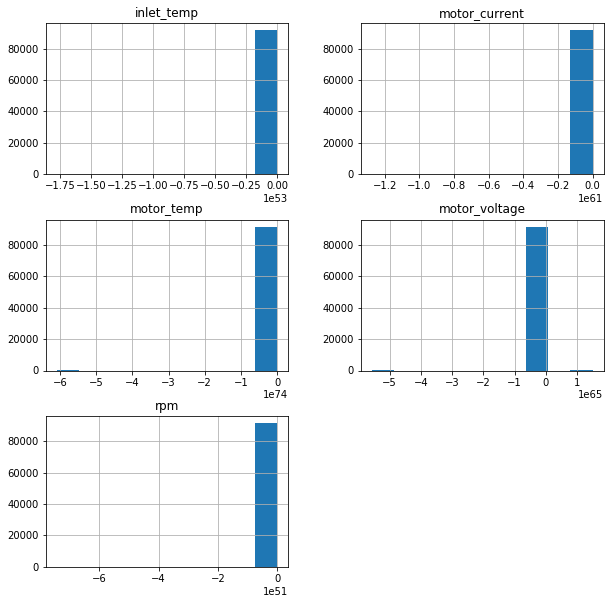

In [5]:
rms.hist(figsize=(10,10))

In [196]:
units = [0,20]
helper = HelperFunction()
file_paths = helper.generate_file_paths(units)
file_paths

{'sensor0': ['data/train/unit0000_rms.csv', 'data/train/unit0000_alarms.csv'],
 'sensor1': ['data/train/unit0001_rms.csv', 'data/train/unit0001_alarms.csv'],
 'sensor2': ['data/train/unit0002_rms.csv', 'data/train/unit0002_alarms.csv'],
 'sensor3': ['data/train/unit0003_rms.csv', 'data/train/unit0003_alarms.csv'],
 'sensor4': ['data/train/unit0004_rms.csv', 'data/train/unit0004_alarms.csv'],
 'sensor5': ['data/train/unit0005_rms.csv', 'data/train/unit0005_alarms.csv'],
 'sensor6': ['data/train/unit0006_rms.csv', 'data/train/unit0006_alarms.csv'],
 'sensor7': ['data/train/unit0007_rms.csv', 'data/train/unit0007_alarms.csv'],
 'sensor8': ['data/train/unit0008_rms.csv', 'data/train/unit0008_alarms.csv'],
 'sensor9': ['data/train/unit0009_rms.csv', 'data/train/unit0009_alarms.csv'],
 'sensor10': ['data/train/unit0010_rms.csv', 'data/train/unit0010_alarms.csv'],
 'sensor11': ['data/train/unit0011_rms.csv', 'data/train/unit0011_alarms.csv'],
 'sensor12': ['data/train/unit0012_rms.csv', 'data

In [197]:
helper.generate_file_paths([20,50], False)

{'sensor20': ['data/test/unit0020_rms.csv', 'data/test/unit0020_alarms.csv'],
 'sensor21': ['data/test/unit0021_rms.csv', 'data/test/unit0021_alarms.csv'],
 'sensor22': ['data/test/unit0022_rms.csv', 'data/test/unit0022_alarms.csv'],
 'sensor23': ['data/test/unit0023_rms.csv', 'data/test/unit0023_alarms.csv'],
 'sensor24': ['data/test/unit0024_rms.csv', 'data/test/unit0024_alarms.csv'],
 'sensor25': ['data/test/unit0025_rms.csv', 'data/test/unit0025_alarms.csv'],
 'sensor26': ['data/test/unit0026_rms.csv', 'data/test/unit0026_alarms.csv'],
 'sensor27': ['data/test/unit0027_rms.csv', 'data/test/unit0027_alarms.csv'],
 'sensor28': ['data/test/unit0028_rms.csv', 'data/test/unit0028_alarms.csv'],
 'sensor29': ['data/test/unit0029_rms.csv', 'data/test/unit0029_alarms.csv'],
 'sensor30': ['data/test/unit0030_rms.csv', 'data/test/unit0030_alarms.csv'],
 'sensor31': ['data/test/unit0031_rms.csv', 'data/test/unit0031_alarms.csv'],
 'sensor32': ['data/test/unit0032_rms.csv', 'data/test/unit0032_

In [198]:
def get_test_or_train_sensors(units, file_paths = None):
    if file_paths:
        sensors = []
#         import ipdb;ipdb.set_trace()
        for each_sensor in range(units[0], units[1]):
            sensor_var = 'sensor' + str(each_sensor) 
            sensor_obj = RMS(rms_path=file_paths.get(sensor_var)[0], alarm_path = file_paths.get(sensor_var)[1])
            rms_cleaned_df = helper.remove_outliers(sensor_obj.rms)
            sensor_obj.assign_cleaned_df(rms_cleaned_df)
            sensor_obj.noise_free_rms_processed = sensor_obj.noise_free_rms.copy()
            sensor_obj.noise_free_rms_processed.reset_index(level=0, inplace=True)
            sensor_obj.noise_free_rms_processed['timestamp'] = pd.to_datetime(sensor_obj.noise_free_rms_processed['index'], 
                                                                              format="%Y-%m-%d %H:%M:%S")
            sensor_obj.noise_free_rms_processed['power'] = sensor_obj.noise_free_rms_processed['motor_voltage'] *  sensor_obj.noise_free_rms_processed['motor_voltage']
            sensor_obj.noise_free_rms_processed['temp_diff'] = sensor_obj.noise_free_rms_processed['motor_temp'] -  sensor_obj.noise_free_rms_processed['inlet_temp']

            sensors.append(sensor_obj)
            del sensor_obj
        return sensors

In [199]:
sensors = get_test_or_train_sensors([0,20],helper.generate_file_paths(units))

In [200]:
test_sensors = get_test_or_train_sensors([20,50], helper.generate_file_paths([20,50], False))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1661ed588>,
      dtype=object)

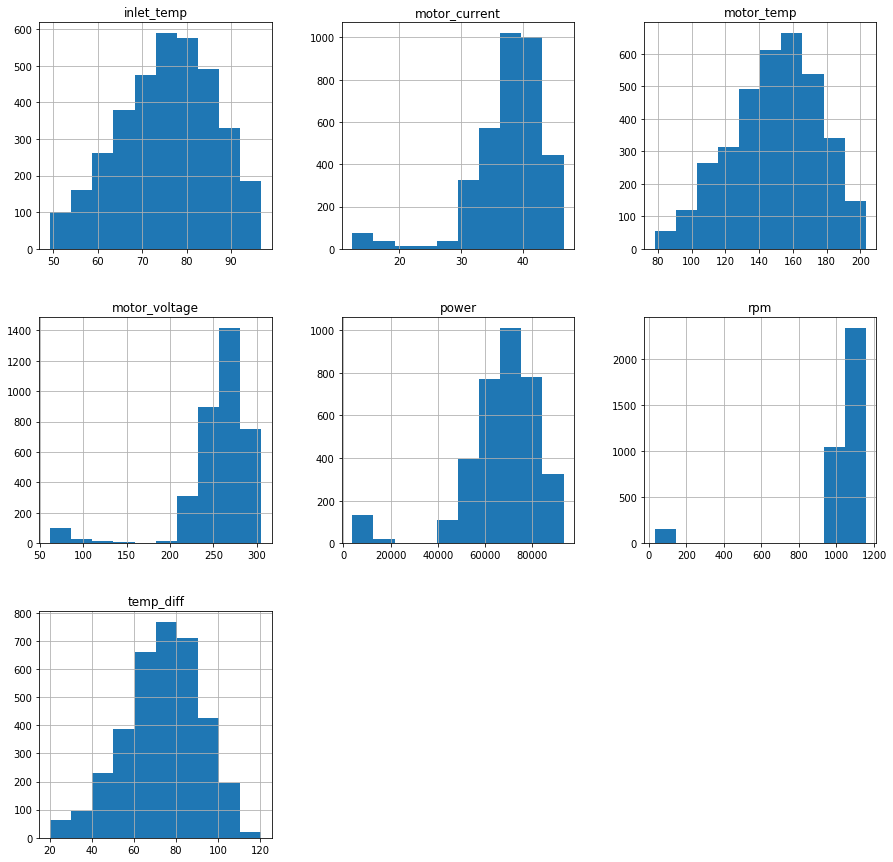

In [201]:
test_sensors[0].noise_free_rms_processed.hist(figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x18ab455f8>,
      dtype=object)

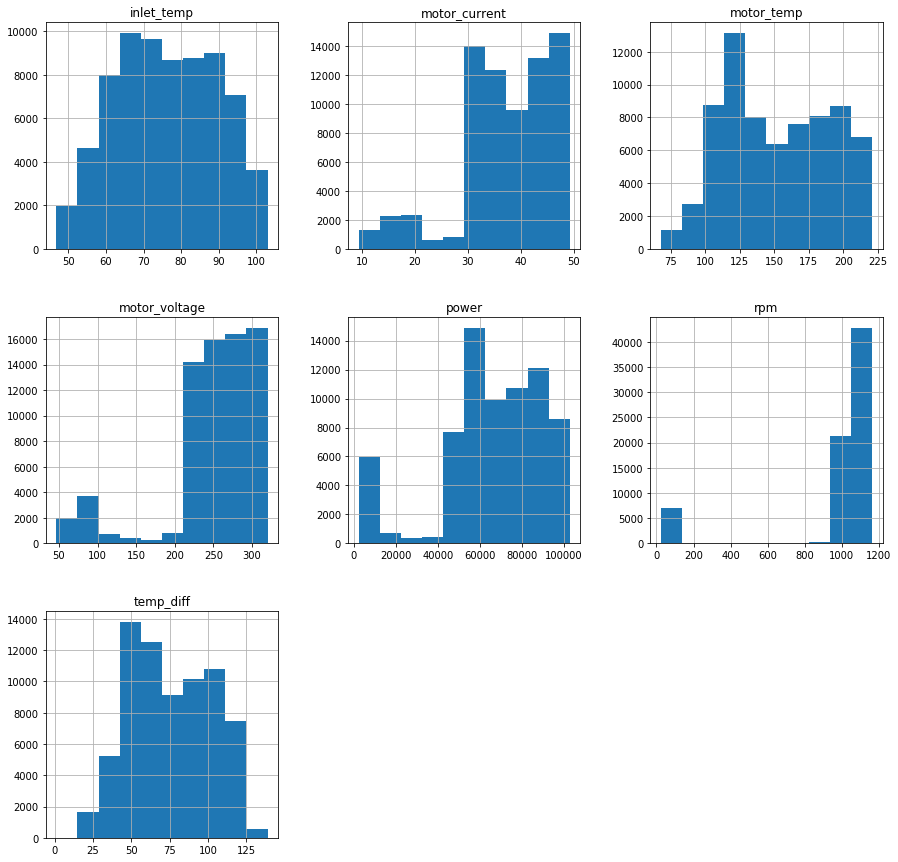

In [202]:
sensors[0].noise_free_rms_processed.hist(figsize=(15,15))

In [13]:
sensors[2].plotly_rms_ts(sensors[2].noise_free_rms_processed, title = "Sensor2: Denoised")

/Users/ajeyakempegowda/.virtualenvs/tagup/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning:

Consider using IPython.display.IFrame instead



In [121]:
sensors[9].plotly_rms_ts(sensors[9].noise_free_rms_processed, title = "Sensor9: Denoised")

The draw time for this plot will be slow for clients without much RAM.


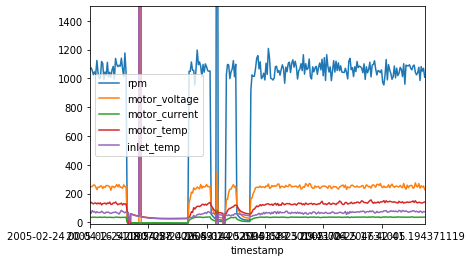

In [128]:
sensors[9].rms.loc["2005-02-24":"2005-02-26"].plot(ylim=(-10, 1500))

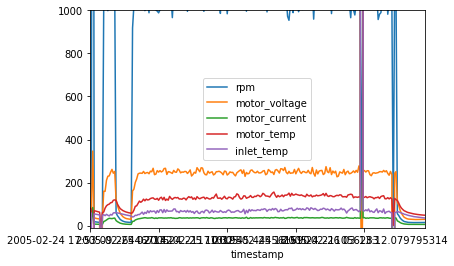

In [130]:
sensors[9].rms.loc["2005-02-24 17:52:05.042022256":"2005-02-26 10:39:35.505043604"].plot(ylim=(-10, 1000))

In [9]:
sensors[19].plotly_rms_ts(sensors[19].noise_free_rms_processed, title = "Sensor19: Denoised")

The draw time for this plot will be slow for all clients.


/Users/ajeyakempegowda/.virtualenvs/tagup/lib/python3.6/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Too Long



In [14]:
def plot_heatmaps(sensor):
    cols = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 'inlet_temp']

    f = plt.figure(figsize=(10, 10))
    plt.matshow(sensor.noise_free_rms_processed[cols].corr(), fignum=f.number)
    plt.xticks(range(len(cols)), cols, fontsize=14, rotation=90)
    plt.yticks(range(len(cols)), cols, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)

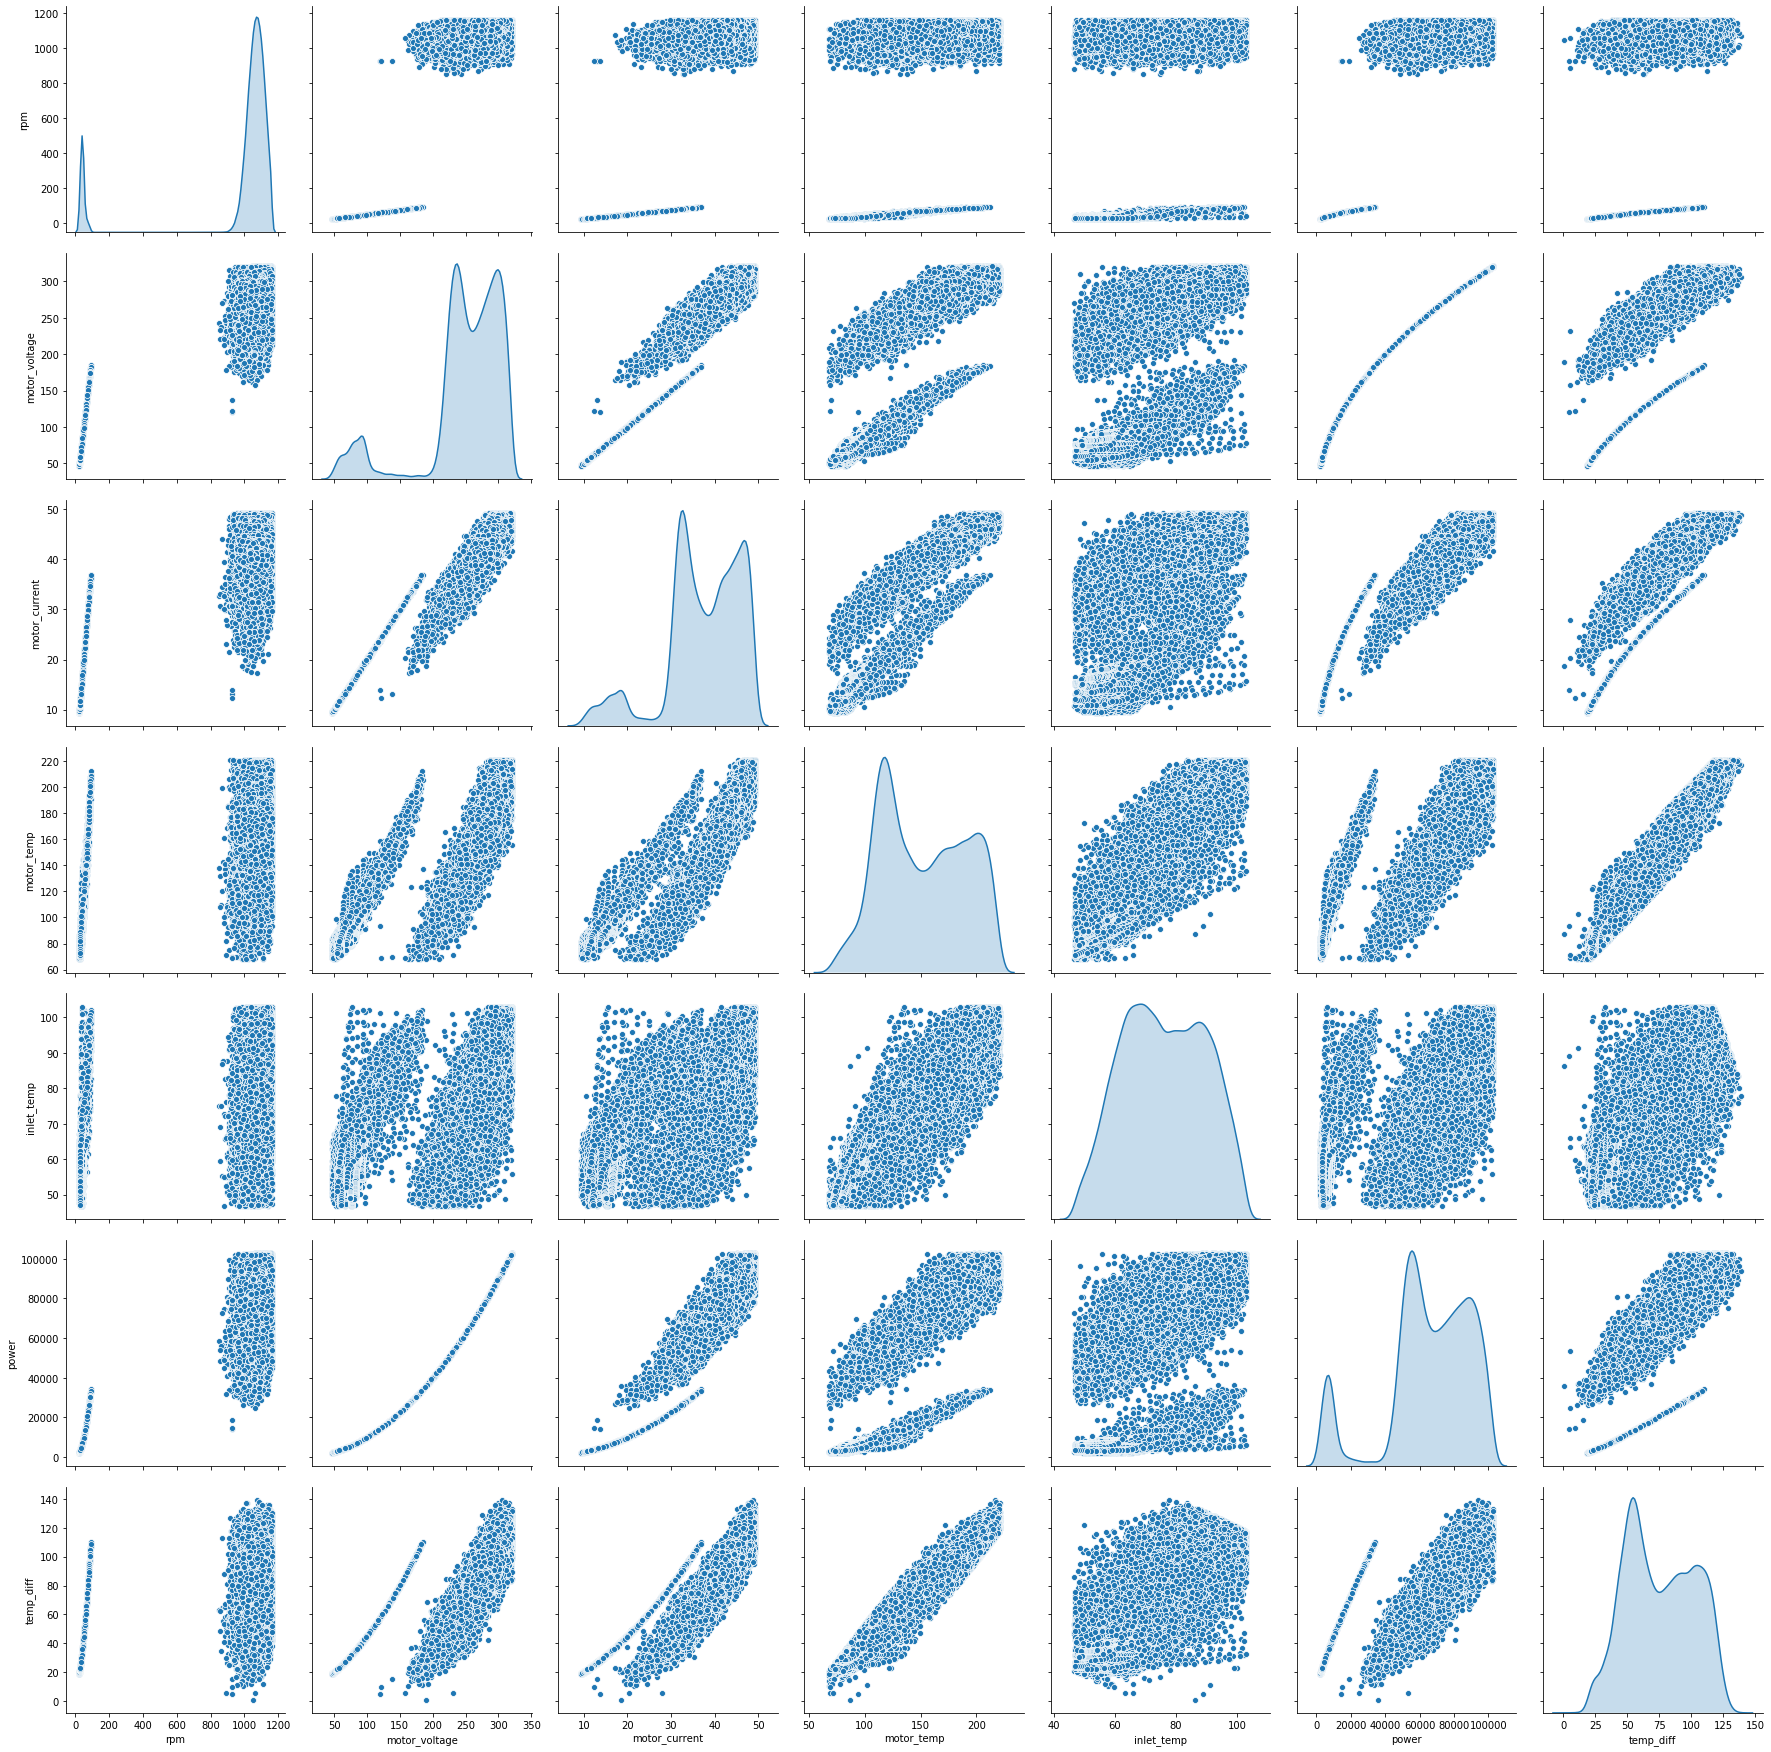

In [15]:
sns.pairplot(sensors[0].noise_free_rms_processed,  palette="Set2", diag_kind="kde", height=3.5)

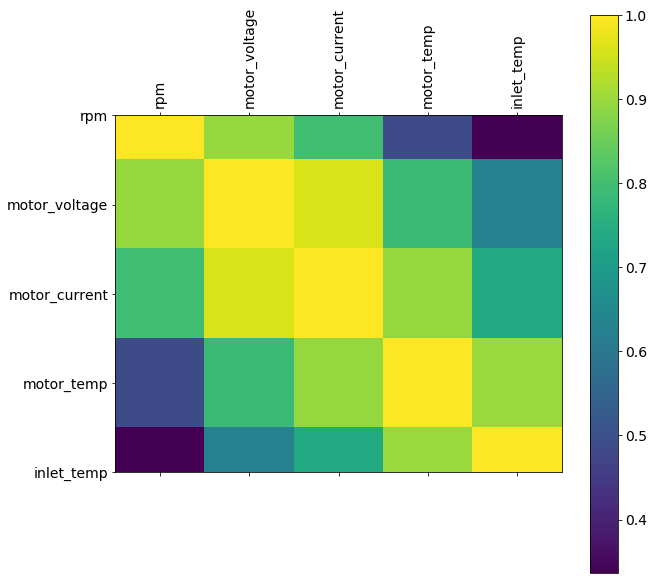

In [16]:
plot_heatmaps(sensors[1])

In [17]:
frames = []
for i in sensors:
    frames.append(i.noise_free_rms_processed)
result = pd.concat(frames)
result.head()

temp_df = result[:30000]

In [18]:
result.shape

(775374, 9)

In [384]:
#Sensor 19 which had the highest working life
def plot_clusters(data, col):
    plt.figure(figsize=(10,10))
    cols = ['rpm','motor_voltage','motor_current','motor_temp','inlet_temp','power','temp_diff']
    model = KMeans(n_clusters=2)
    model.fit(data[cols],data[col])
    plt.xlabel('Timeline ',fontsize = 10)
    plt.ylabel('{}'.format(col.upper()),fontsize = 10)
    plt.title('{} vs. Time'.format(col.upper()),fontsize = 10)
    return plt.scatter(range(len(data['rpm'])),data[col],c=model.labels_)

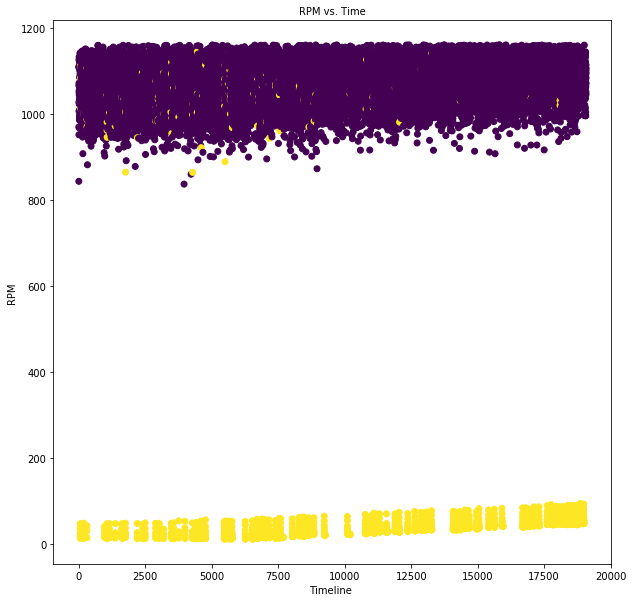

In [385]:
plot_clusters(sensors[19].noise_free_rms_processed, 'rpm')

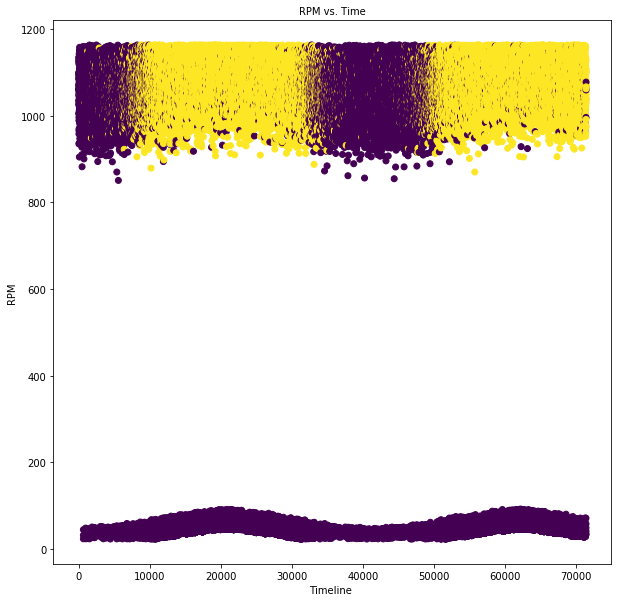

In [386]:
plot_clusters(sensors[0].noise_free_rms_processed, 'rpm')

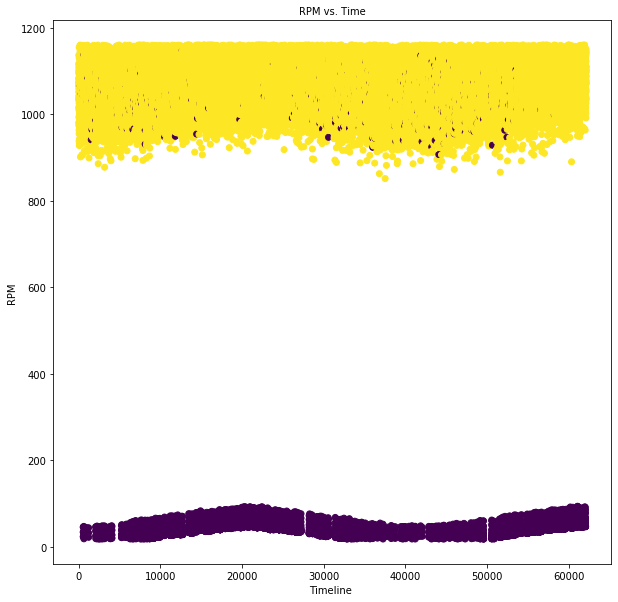

In [387]:
plot_clusters(sensors[12].noise_free_rms_processed, 'rpm')

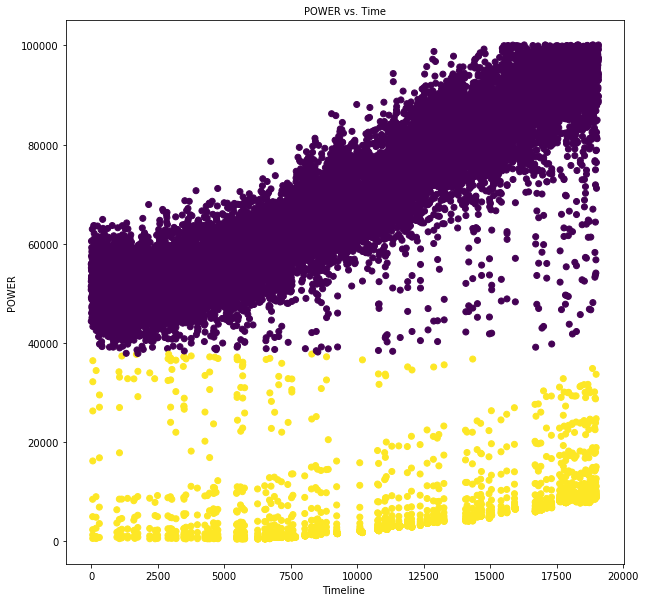

In [388]:
plot_clusters(sensors[19].noise_free_rms_processed, 'power')

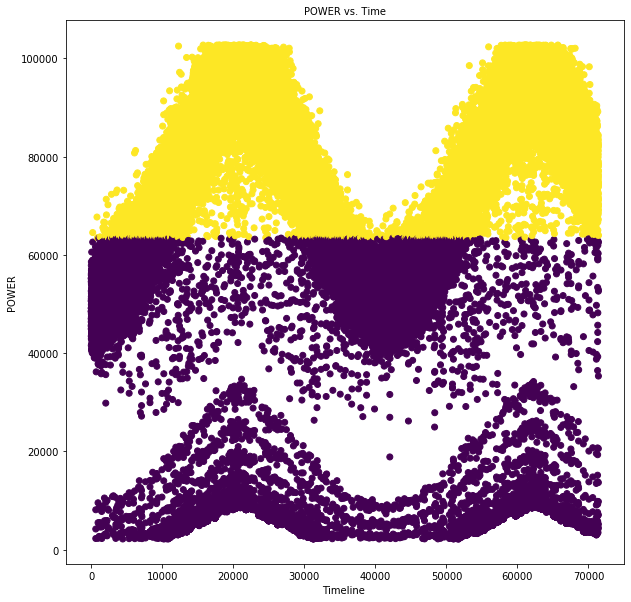

In [389]:
plot_clusters(sensors[0].noise_free_rms_processed, 'power')

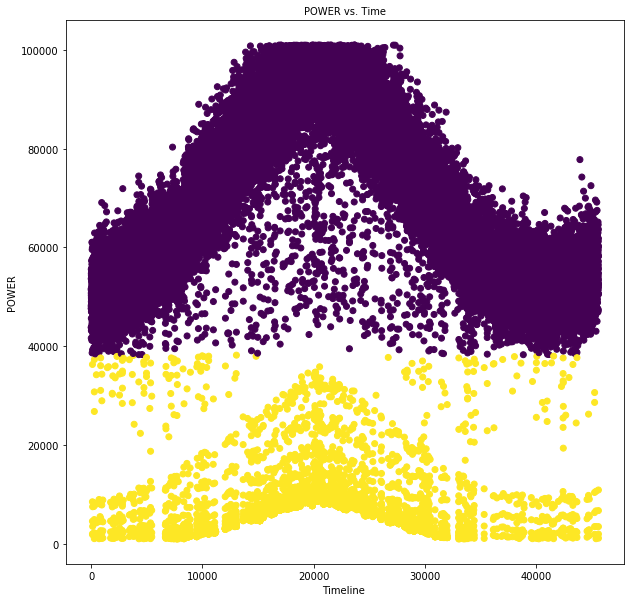

In [390]:
plot_clusters(sensors[11].noise_free_rms_processed, 'power')

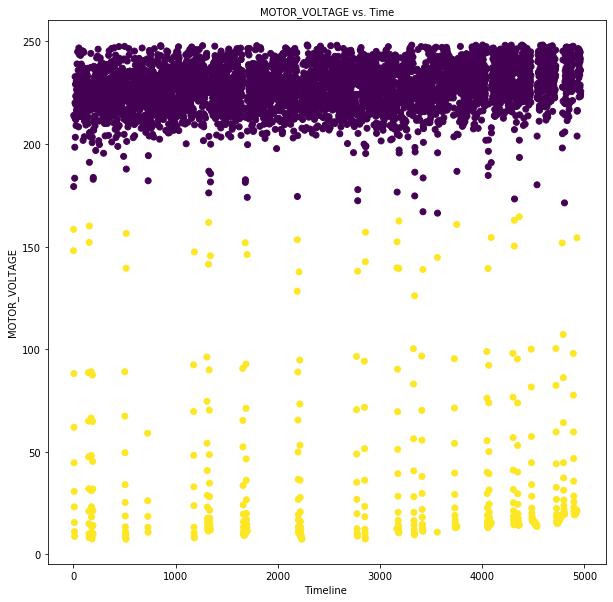

In [391]:
plot_clusters(sensors[15].noise_free_rms_processed, 'motor_voltage')

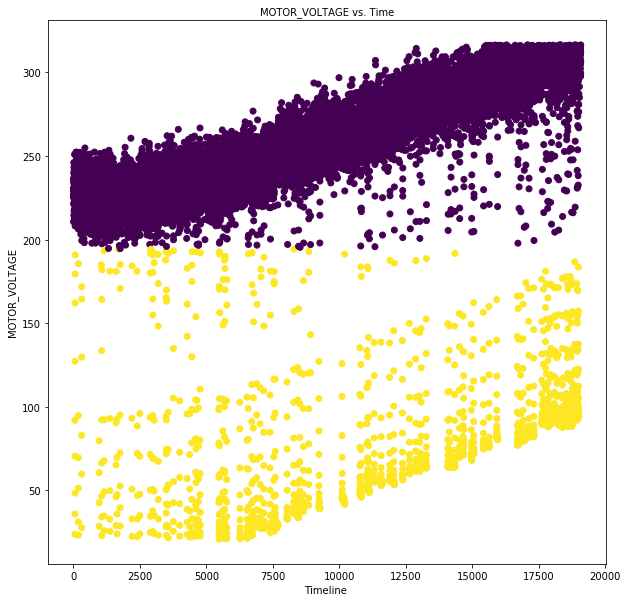

In [392]:
plot_clusters(sensors[19].noise_free_rms_processed, 'motor_voltage')

### 3D plots for interactive graph that show clear clustering 

In [393]:
def create_3d_plot(x, y, z):
    trace1 = go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=12,colorscale='Viridis',opacity=0.8))
    data = [trace1]
    layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='3d-scatter-colorscale')

create_3d_plot(x=temp_df['rpm'],y=temp_df['power'],z=temp_df['temp_diff'])

In [394]:
create_3d_plot(x=temp_df['rpm'],y=temp_df['motor_current'],z=temp_df['temp_diff'])

## Survival modeling
#### Reference: https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

In [131]:
def get_working_days(sensors):
    working_life = []
    v_std, i_std, p_std, rpm_std = [], [], [], []
    for each_s in sensors:
        desc = each_s.noise_free_rms_processed.describe()
        working_life.append(
            (each_s.noise_free_rms_processed['timestamp'].max()-
             each_s.noise_free_rms_processed['timestamp'].min()).days)
        v_std.append(desc['motor_voltage']['std'])
        i_std.append(desc['motor_current']['std'])
        p_std.append(desc['power']['std'])
        rpm_std.append(desc['rpm']['std'])
    return working_life, v_std, i_std, p_std, rpm_std
sensor_life, v_std, i_std, p_std, rpm_std = get_working_days(sensors)

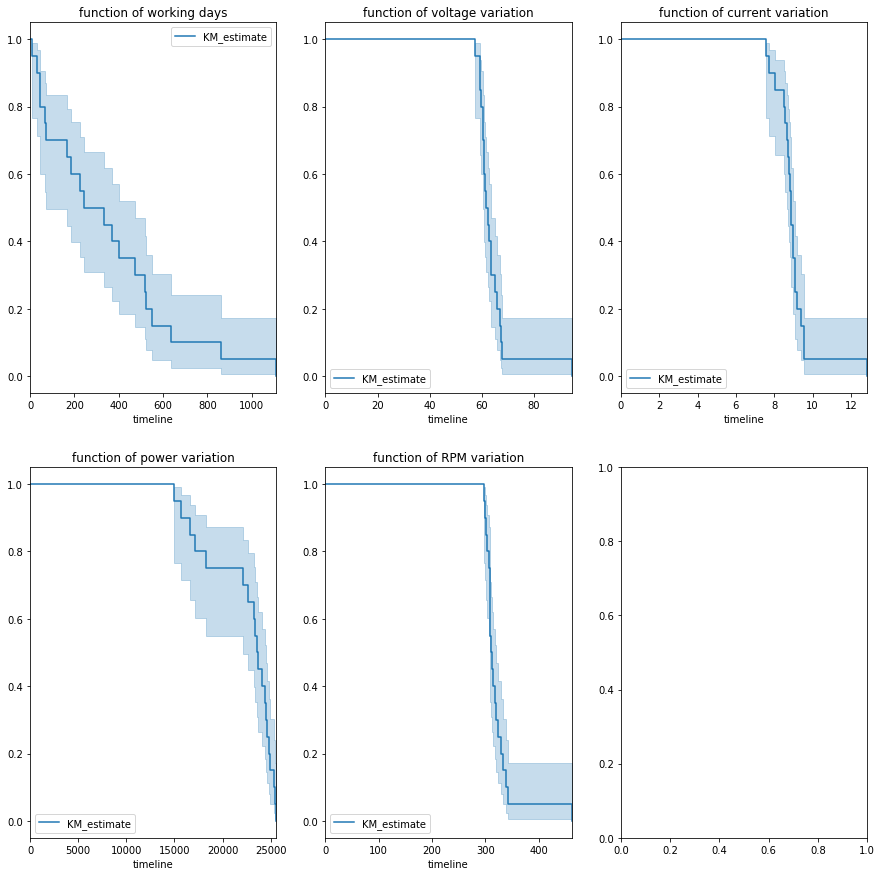

In [146]:
from lifelines import KaplanMeierFitter
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.reshape(6,)
titles = ["function of working days",
         "function of voltage variation",
         "function of current variation",
         "function of power variation",
         "function of RPM variation"]
for i, model in enumerate([sensor_life, v_std, i_std, p_std, rpm_std]):
    axes[i].set_title(titles[i])
    KaplanMeierFitter(alpha=0.1).fit(durations = model, event_observed = [1]*len(model)).plot(ax=axes[i],)
plt.show()

## We can also investigate hazard over time instead of survival:

#### Reference: http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf

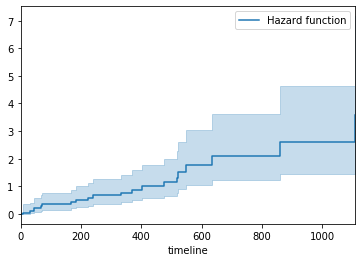

In [139]:
from lifelines import NelsonAalenFitter

fitter = NelsonAalenFitter()
fitter.fit(sensor_life, event_observed=[1]*len(sensor_life), label="Hazard function")
fitter.plot(show_censors=True)

### ARIMA Approach

In [79]:
def evaluate_arima_model(X, arima_order):
#     import ipdb;ipdb.set_trace()
    train_size = int(len(X) * 0.66)
    train, test = train_test_split(te, test_size=0.34)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except Exception as e:
                    print(e.args)
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
# evaluate parameters
p_values = [0,1,2, 3, 4, 5]
d_values = range(0, 4)
q_values = range(0, 4)

In [80]:
warnings.filterwarnings("ignore")
evaluate_models(sensors[0].noise_free_rms_processed['rpm'][:50], p_values, d_values, q_values)

(0, 0, 0)
ARIMA(0, 0, 0) MSE=2643.894
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 1, 3)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 2, 3)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 3, 0)
('d > 2 is not supported',)
(0, 3, 1)
('d > 2 is not supported',)
(0, 3, 2)
('d > 2 is not supported',)
(0, 3, 3)
('d > 2 is not supported',)
(1, 0, 0)
ARIMA(1, 0, 0) MSE=255

                             ARIMA Model Results                              
Dep. Variable:                  D.rpm   No. Observations:                71406
Model:                 ARIMA(1, 1, 3)   Log Likelihood             -448691.357
Method:                       css-mle   S.D. of innovations            129.632
Date:                Fri, 19 Jul 2019   AIC                         897394.713
Time:                        21:12:17   BIC                         897449.770
Sample:                             1   HQIC                        897411.678
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0006      0.005     -0.115      0.909      -0.010       0.009
ar.L1.D.rpm     0.9067      0.002    450.961      0.000       0.903       0.911
ma.L1.D.rpm    -1.0505      0.004   -251.217    

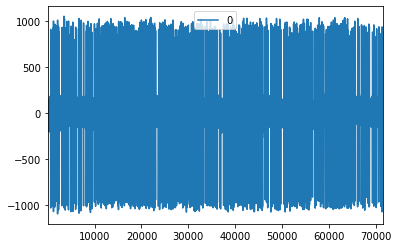

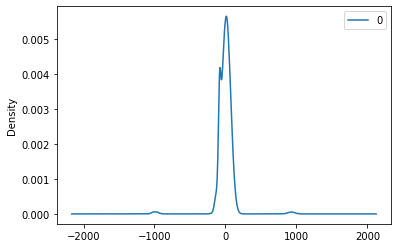

                  0
count  71406.000000
mean      -0.010540
std      129.634389
min    -1093.120322
25%      -49.303901
50%        2.156555
75%       47.047988
max     1051.594558


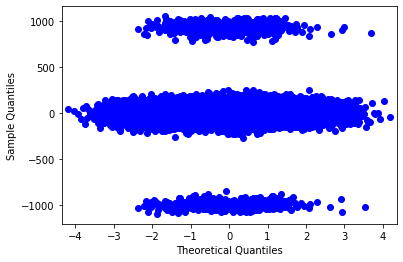

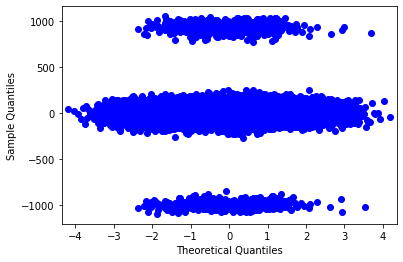

In [82]:
cols = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp','inlet_temp',  'power', 'temp_diff']
data = pd.Series(sensors[0].noise_free_rms_processed['rpm'])
model = ARIMA(data,order=(1, 1, 3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
qqplot(residuals)


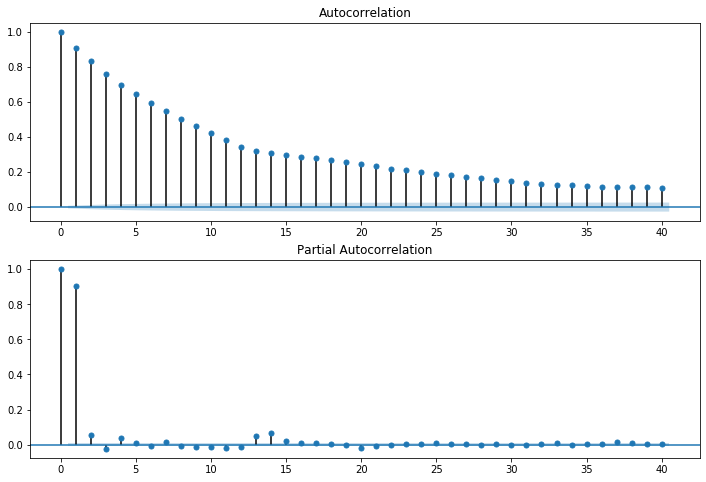

In [207]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sensors[0].noise_free_rms['rpm'].squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sensors[0].noise_free_rms['rpm'], lags=40, ax=ax2)

In [208]:
arma_mod20 = sm.tsa.ARMA(sensors[0].noise_free_rms['rpm'], (2,0)).fit(disp=False)
print(arma_mod20.params)

const        968.202945
ar.L1.rpm      0.854482
ar.L2.rpm      0.057416
dtype: float64


In [209]:
arma_mod30 = sm.tsa.ARMA(sensors[0].noise_free_rms['rpm'], (3,0)).fit(disp=False)
print(arma_mod30.params)

const        968.202945
ar.L1.rpm      0.855840
ar.L2.rpm      0.077630
ar.L3.rpm     -0.023656
dtype: float64


In [210]:
print("--- arma_mod20 models params --")
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)
print("=============================")
print("--- arma_mod30 models params --")
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)
print("=============================")

--- arma_mod20 models params --
897537.0276610606 897573.7322657915 897548.337918255
--- arma_mod30 models params --
897499.0554035543 897544.936159468 897513.1932250474


In [212]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9981344724949541

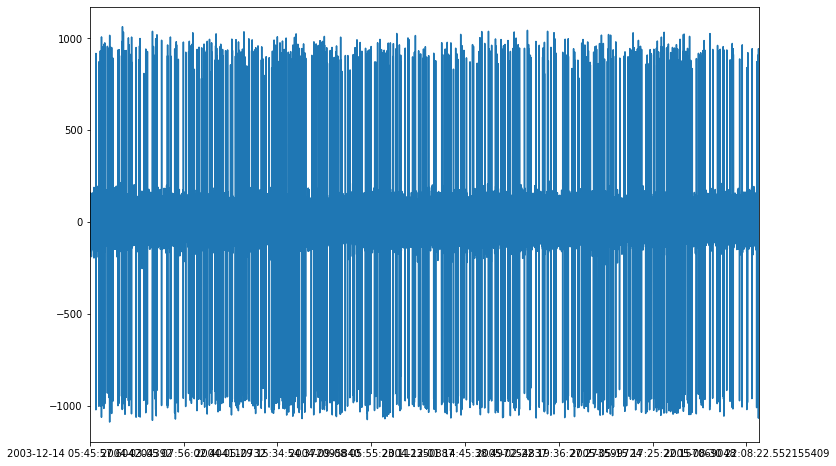

In [213]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax)

#### Residual plot doesn't give much information about how good our model is as the residual plot is pretty hard to understand. Let's plot QQplot to understand more

In [214]:
resid = arma_mod30.resid
stats.normaltest(resid)

NormaltestResult(statistic=24960.880538976213, pvalue=0.0)

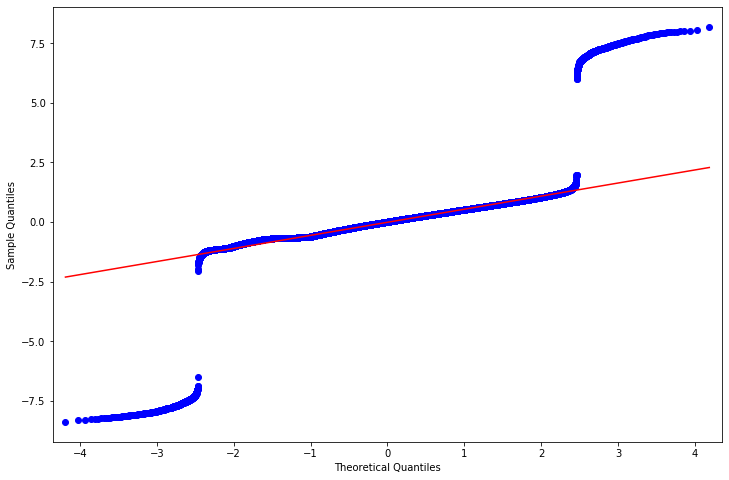

In [215]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

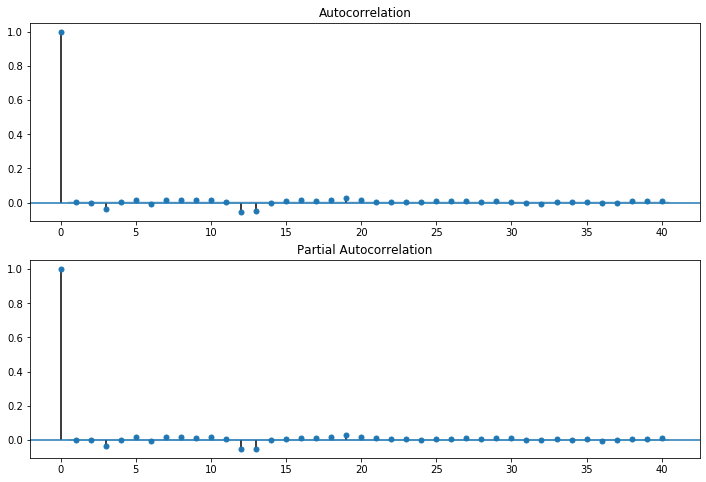

In [216]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [278]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax = sensors[0].noise_free_rms.loc['2005-09-10 17:36:47.236452969':].plot(ax=ax)
# fig = arma_mod30.plot_predict(start = '2005-09-10 17:36:47.236452969',dynamic=True, ax=ax, plot_insample=True)
arma_mod30.predict(start='2005-09-10 17:36:47.236452969', end = '2005-09-11')

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [263]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
mean_forecast_err(sensors[0].noise_free_rms['rpm'], predict_sunspots)

0.0013226780413007394

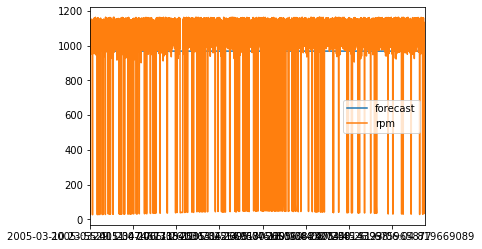

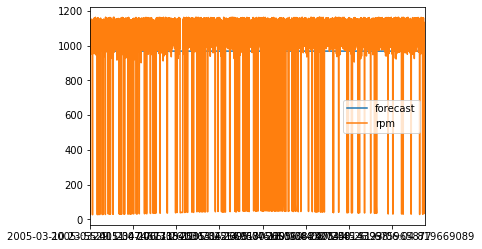

In [262]:
arma_mod30.plot_predict(start='2005-03-10 23:55:41.234746771', dynamic=True)

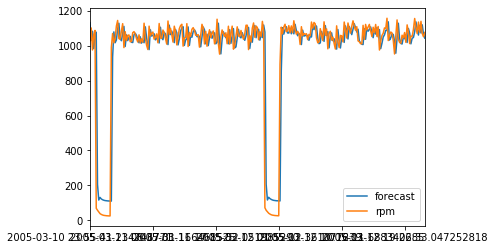

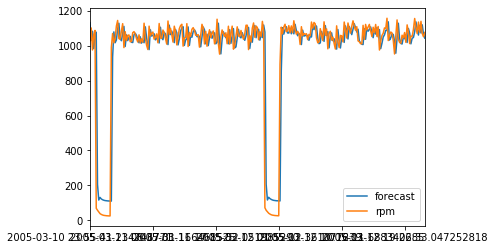

In [250]:
arma_mod30.plot_predict(start = '2005-03-10 23:55:41.234746771', end = '2005-03-12 22:05:32.183090259')

In [415]:
X = sensors[19].noise_free_rms_processed[cols]
y = sensors[19].noise_free_rms_processed['rpm']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.20, random_state = 19)

In [416]:
def preprocess(X, y, window = 5):
    pred, target = [], []
    for i in range(window, len(X)):
        pred.append(X.iloc[i-window:i].values)
        target.append(X['rpm'].iloc[i])
    X_p, y_p = np.array(pred), np.array(target)
    X_p = np.reshape(X_p, (X_p.shape[0], X_p.shape[1], len(X.columns)))
    return X_p, y_p

In [417]:
X_train, y_train = preprocess(X_train, y_train)
X_valid, y_valid = preprocess(X_valid, y_valid)

In [439]:
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

model = Sequential()
model.add(LSTM(units=200, return_sequences=False, input_shape=(5, len(X.columns))))
model.add(Dropout(rate =0.2))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=200)

# y_pred = classifier.predict(X_valid)
# y_pred = (y_pred > 0.5)

Epoch 1/10
15257/15257 [==============================] - 3s 192us/step - loss: 1019507.5150
Epoch 2/10
15257/15257 [==============================] - 2s 111us/step - loss: 1012299.4317
Epoch 3/10
15257/15257 [==============================] - 2s 114us/step - loss: 1005465.9327
Epoch 4/10
15257/15257 [==============================] - 2s 112us/step - loss: 998760.2517
Epoch 5/10
15257/15257 [==============================] - 2s 114us/step - loss: 992098.3393
Epoch 6/10
15257/15257 [==============================] - 2s 119us/step - loss: 985370.0960
Epoch 7/10
15257/15257 [==============================] - 2s 123us/step - loss: 978728.6673
Epoch 8/10
15257/15257 [==============================] - 2s 126us/step - loss: 972163.2924
Epoch 9/10
15257/15257 [==============================] - 2s 126us/step - loss: 965571.5268
Epoch 10/10
15257/15257 [==============================] - 2s 128us/step - loss: 959063.6523


In [440]:
predictions = model.predict(X_valid)

https://stats.stackexchange.com/questions/71802/variable-selection-in-time-series-forecasting

https://www.researchgate.net/post/How_can_I_make_a_time-series_stationary

http://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf

https://www.researchgate.net/post/p_value_of_0000

http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf

http://ceur-ws.org/Vol-1649/123.pdf

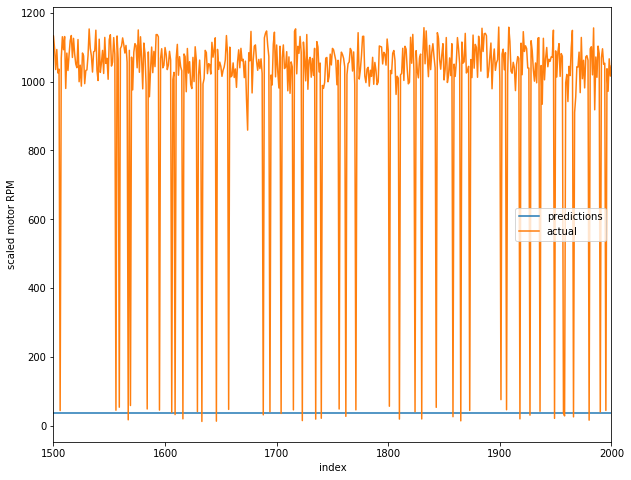

In [441]:

plt.figure(figsize=(10,8))
plt.plot(predictions)
plt.plot(y_valid)
plt.ylabel('scaled motor RPM')
plt.xlabel('index')
plt.legend(['predictions', 'actual'])
plt.xlim((1500, 2000))
plt.show()

In [442]:
X_valid

array([[[1.05699896e+03, 2.98492034e+02, 4.67427185e+01, ...,
         6.80133973e+01, 8.90974943e+04, 1.02575140e+02],
        [1.04047912e+03, 2.21870588e+02, 2.91882940e+01, ...,
         5.32832684e+01, 4.92265577e+04, 3.45885830e+01],
        [1.03131255e+03, 2.70272345e+02, 4.11533211e+01, ...,
         7.05355439e+01, 7.30471406e+04, 7.21098545e+01],
        [1.03747046e+03, 2.97259757e+02, 4.20403438e+01, ...,
         9.59444042e+01, 8.83633633e+04, 8.69913545e+01],
        [1.06010390e+03, 2.90575129e+02, 4.46810013e+01, ...,
         8.79972527e+01, 8.44339059e+04, 1.01105709e+02]],

       [[1.04047912e+03, 2.21870588e+02, 2.91882940e+01, ...,
         5.32832684e+01, 4.92265577e+04, 3.45885830e+01],
        [1.03131255e+03, 2.70272345e+02, 4.11533211e+01, ...,
         7.05355439e+01, 7.30471406e+04, 7.21098545e+01],
        [1.03747046e+03, 2.97259757e+02, 4.20403438e+01, ...,
         9.59444042e+01, 8.83633633e+04, 8.69913545e+01],
        [1.06010390e+03, 2.90575129e+0